<a href="https://colab.research.google.com/github/SrinithiSaiprasath/Transformer/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
! pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
import logging
logging.getLogger('tensorflow').disabled = True
import re
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
! pip install PyPDF2 pdfplumber
from PyPDF2 import PdfReader
import pdfplumber
import re
import csv,re
from PIL import Image
import os
from google.colab import drive
drive.mount('/content/drive' ,force_remount  = True)
# ! pip install silence_tensorflow PyPDF2 pdfplumber tensorflow tensorflow_datasets matplotlib numpy pandas


Mounted at /content/drive


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

In [ ]:
# Maximum sentence length
MAX_LENGTH = 20
# For tf.data.Dataset
BATCH_SIZE = int(64 * strategy.num_replicas_in_sync)
# BATCH_SIZE = 64
BUFFER_SIZE = 20000
# For Transformer
NUM_LAYERS = 6 #6
D_MODEL = 512 #512
NUM_HEADS = 8
UNITS = 2048 #2048
DROPOUT = 0.5
EPOCHS = 500

TEXT PREPROCESS

Requirement : It removes noise, standardizes the text,accents, strips special characters, and reduces variability in the data, which can improve the model's accuracy and performance.

Eg : Heyyyy => Hey => hey

In [ ]:
def textPreprocess(input_text):

  def removeAccents(input_text):
      strange='ąćęłńóśżź'
      ascii_replacements='acelnoszz'
      translator=str.maketrans(strange,ascii_replacements)
      return input_text.translate(translator)

  def removeSpecial(input_text):
      special='[^A-Za-z0-9 ]+'
      return re.sub(special, '', input_text)

  def removeTriplicated(input_text):
      return re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', input_text)

  return removeTriplicated(removeSpecial(removeAccents(input_text.lower())))


TOKENIZE : Converting a sequence of text into smaller units

Eg: Hello, How are you ? => ["Hello", ",", "how", "are", "you", "?"]

FILTER : Excluding certain sequences based on predefined criteria

START_TOKEN , END_TOKEN are used to make the model understand how a sentence should start and end and with what kind of charecter.
The sequences are filtered based MAX_LENGTH.

In [ ]:
def tokenize_and_filter(inputs, outputs,START_TOKEN ,END_TOKEN,tokenizer):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

#ATTENTION
Attention is a mechanism used in neural networks, particularly in transformer models, to focus on specific parts of the input sequence which  allows the model to weigh different parts of the input differently, depending on their relevance to the task at hand.

# SCALED DOT PRODUCT ATTENTION
Computes attention using dot products of query and key vectors, scales the result, applies masking if needed, and uses a softmax function where the final output is a weighted sum of the value vectors, providing a context-aware representation for the model to use in its predictions.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  if mask is not None:
    logits += (mask * -1e9)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

## MULTIHEAD ATTENTION
Multi-Head Attention is a mechanism used in transformer models to enhance the model's ability to focus on different parts of the input sequence simultaneously. By having multiple attention "heads," the model can capture various aspects of the data, allowing it to understand more complex patterns and dependencies within the sequence.

Multi-head attention allows the model to attend to different parts of the sequence simultaneously, leading to more nuanced and powerful representations.
Each head can learn different types of relationships and dependencies, making the model more flexible and capable of capturing complex patterns in the data.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

# PADDING MASK
A tensor that indicates the positions of padding tokens in a sequence.Applied in transformer models and other neural networks to handle sequences of varying lengths effectively.
A padding mask is used to prevent the model from considering these padding tokens during its computations, especially in the attention mechanism of transformers.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## POSITIONAL ENCODING
Positional encoding is used to inject information about the relative or absolute position of tokens in a sequence, which is crucial because transformer models do not inherently understand the order of tokens due to their non-sequential processing.


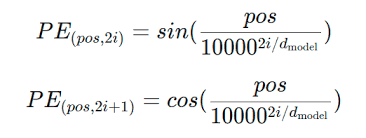

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/positionalencoding.png"))


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
        output = inputs + self.pos_encoding[:, : tf.shape(inputs)[1]]
        return tf.cast(output, dtype=tf.float32)

  def compute_output_shape(self, input_shape):
        batch_size, seq_len, d_model = input_shape
        return (batch_size, seq_len, d_model)


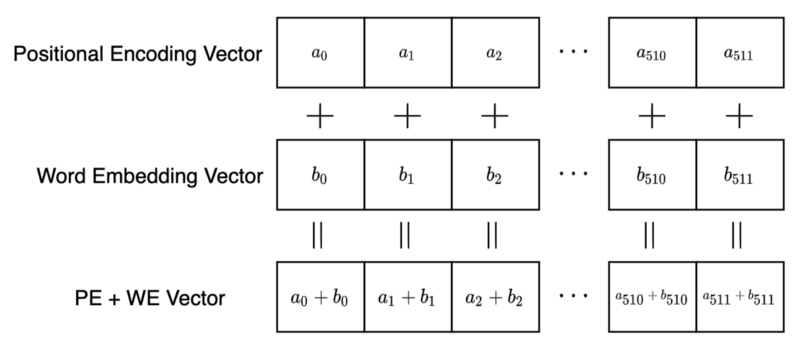

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/pos-encoding-plus-word-embedding.png"))

## ENCODER LAYER
Processes the input sequence and creating a contextualized representation of it.

MHA computes attention weights for each word in the sequence, indicating its relevance to other words.
Add & Norm improve the flow of gradients during backpropogation.FF is used to
understand the non-linear relationship within the sequence.

The encoder layer uses self-attention to weigh the importance of different words in the input sequence when encoding each word. Multiple encoder layers stacked together allow the model to learn increasingly complex and abstract representations of the input


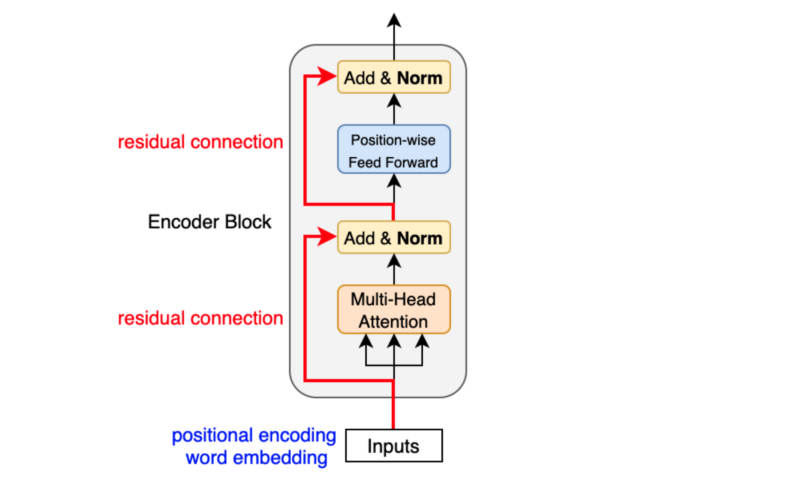

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/encoderlayer.png"))

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):

  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


## ENCODER
(Combination of Input Embeddings + Positional Embeddings + MHA for relation among words  + Add&Norm for predictions)

The encoder processes the entire input sequence in parallel, making it significantly faster for training and inference.Self-attention  in the Encoder allows each word to attend to all other words in the sequence.

Encoder in Encoder Layer : The encoder layer in a transformer uses multi-head attention to calculate the relationships between words in a sequence, then uses a feed forward network to further process the result.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  for i in range(int(num_layers)):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


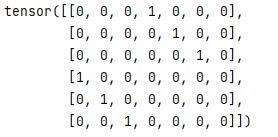

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/encoderoutput.png"))

## DECODER LAYER

 The decoder layer applies multi-head attention to the decoder input, allowing it to focus on relevant parts of the target sequence.
 This attention mechanism helps the decoder to align the target sequence with the input sequence, considering the relationships between words in both sequences.
 The decoder layer uses a feed-forward network to further process the combined information from the two attention mechanisms.

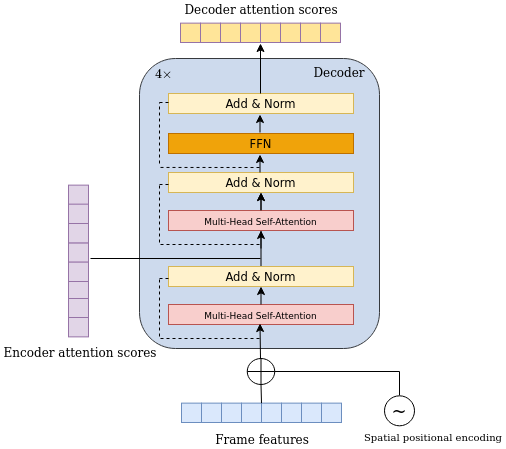

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/decoderlayer.ppm"))

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## DECODER

It takes the encoded representation of the input sequence from the encoder and uses it to predict the next word or token in the output sequence. The decoder uses multi-head attention to focus on different parts of the input and output sequences, allowing it to generate a coherent and contextually appropriate output.

In [ ]:

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(int(num_layers)):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)



## ENCODER-DECODER INTEGRATED WORKING

The encoder first processes the entire input sequence, creating a contextualized representation for each word by considering its relationship with all other words in the sequence. This encoded information is then passed to the decoder.The decoder takes the encoded representation from the encoder and starts generating the output sequence word by word (or token by token).The final output of the decoder is a sequence of probability distributions over the vocabulary, and the word with the highest probability is chosen as the predicted word.

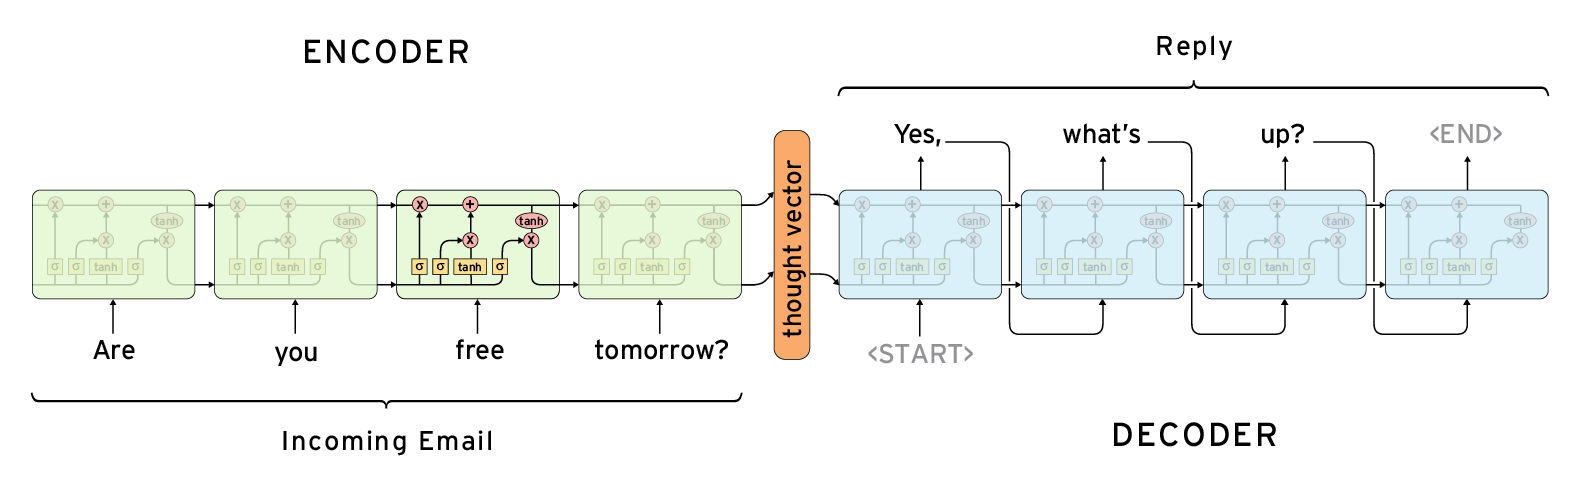

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/encoder-decoder.webp"))

## TRANSFORMER



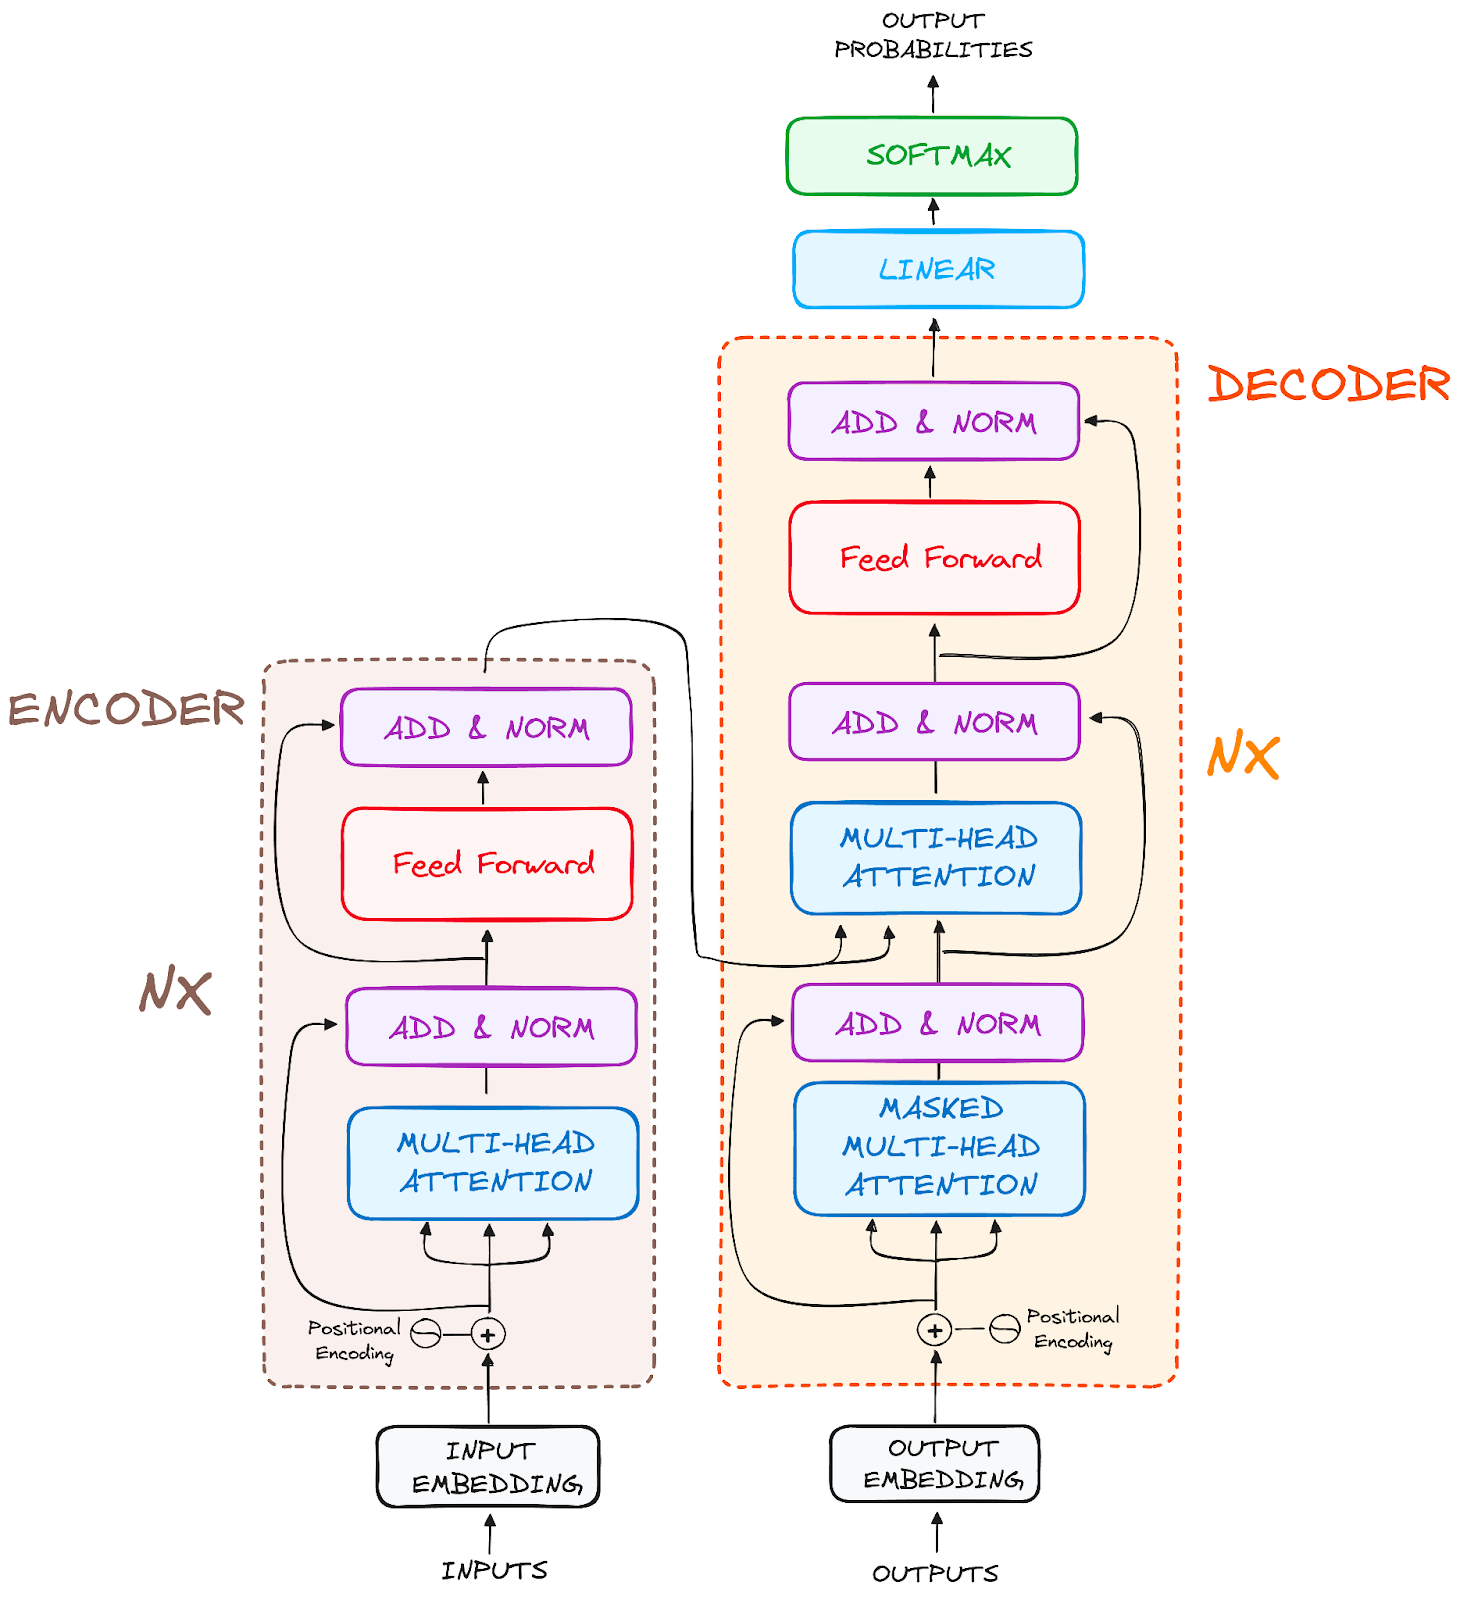

In [ ]:
display(Image.open("/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/formula/transformer.png"))

## ARCHITECTURE



In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [ ]:
def match_seq_len(y_true , y_pred):
   seq_len_pred = tf.shape(y_pred)[1]
   seq_len_true = tf.shape(y_true)[1]
   pad_size = tf.maximum(0, seq_len_pred - seq_len_true)
   y_true_padded = tf.pad(y_true, [[0, 0], [0, pad_size]], constant_values=0)
   y_true_truncated = y_true[:, :seq_len_pred]
   y_true_adjusted = tf.cond(seq_len_true < seq_len_pred,lambda: y_true_padded,lambda: y_true_truncated)

   return y_true_adjusted, y_pred

## LOSS FUNCTION
The loss function calculates the difference between the model's predictions and the actual target values. This difference is a measure of how well the model is performing.

In [ ]:

def loss_function(y_true, y_pred):
  y_true , y_pred = match_seq_len(y_true , y_pred)
  y_true = tf.reshape(y_true, shape=(-1,  tf.shape(y_pred)[1]))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)
  return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())



## CUSTOM SCHEDULE

. It calculates the learning rate for your model during training. The learning rate is a crucial parameter that determines how much the model's weights are adjusted during each training step.

This schedule helps the model learn effectively by starting with small steps (warmup) and then gradually taking larger steps, eventually reducing the step size (decay) to fine-tune the learning process.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
optimizer = tf.keras.optimizers.Adam()


In [ ]:
output_file =  "/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/Dataset/CSV_Dataset/output_file.csv"
def evaluate(sentence, model):
  df = pd.read_csv(output_file)
  df['question'] = df["question"].apply(lambda x: textPreprocess(str(x)))
  df['answer'] = df["answer"].apply(lambda x: textPreprocess(str(x)))
  questions, answers = df['question'].tolist(), df['answer'].tolist()
  START_TOKEN,END_TOKEN,VOCAB_SIZE,tokenizer =get_vocab_size(questions,answers)

  questions, answers = tokenize_and_filter(questions, answers,START_TOKEN , END_TOKEN,tokenizer)
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)


    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence,model):
  df = pd.read_csv(output_file)
  df['question'] = df["question"].apply(lambda x: textPreprocess(str(x)))
  df['answer'] = df["answer"].apply(lambda x: textPreprocess(str(x)))
  questions, answers = df['question'].tolist(), df['answer'].tolist()
  START_TOKEN,END_TOKEN,VOCAB_SIZE,tokenizer =get_vocab_size(questions,answers)

  questions, answers = tokenize_and_filter(questions, answers,START_TOKEN , END_TOKEN,tokenizer)
  prediction = evaluate(sentence,model)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


## PDF TEXT EXTRACTION

1.PDF is read and the subheadings and topics are individually split into context and content and put into a csv file .

2.The csv file is then learn by the transformer to learn the content in the form of question and answer.

3.The model is to be trained for about 100epoch for better language understanding.

4.The model is saved in the form of the a weights.h5 file where the predicted weights are stored.

5.Aftre training,the trained weights shall alone be loaded again for using the chatbot and it need not run for all the epoch every time.

In [ ]:
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

In [ ]:

def categorize_text_as_heading_content(text):
    # Pattern for headings (all-caps assumed as headings)
    heading_pattern = re.compile(r'^[A-Z\s]{2,}$')

    lines = text.splitlines()
    categorized_content = []
    current_heading = None
    current_content = []

    for line in lines:
        stripped_line = line.strip()
        if heading_pattern.match(stripped_line):
            if current_heading:
                # Finalize the previous heading and its content
                categorized_content.append((current_heading, " ".join(current_content)))
                current_content = []
            current_heading = stripped_line
        else:
            current_content.append(stripped_line)

    # Add any remaining content under the last heading
    if current_heading:
        categorized_content.append((current_heading, " ".join(current_content)))

    return categorized_content

In [ ]:
def process_pdf(file_path):
    with pdfplumber.open(file_path) as pdf:
        full_text = ""
        for page in pdf.pages:
            full_text += page.extract_text() + "\n"

        categorized_content = categorize_text_as_heading_content(full_text)
        return categorized_content


In [ ]:
import csv
def convert_to_csv(pdf_path,output_file = "/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/Dataset/CSV_Dataset/output_file.csv"):
    with open(output_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['question', 'answer'])  # Write the header
        content = process_pdf(pdf_path)
        for heading, contents in content:
            writer.writerow([heading, contents])


In [ ]:
def get_vocab_size(questions,answers):
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        questions + answers, target_vocab_size=2**13)
    START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

    # Vocabulary size plus start and end token
    VOCAB_SIZE = tokenizer.vocab_size + 2

    return START_TOKEN, END_TOKEN , VOCAB_SIZE , tokenizer

In [ ]:
def model_fit(output_file = "/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/Dataset/CSV_Dataset/output_file.csv"):
    df = pd.read_csv(output_file)
    df['question'] = df["question"].apply(lambda x: textPreprocess(str(x)))
    df['answer'] = df["answer"].apply(lambda x: textPreprocess(str(x)))
    questions, answers = df['question'].tolist(), df['answer'].tolist()
    START_TOKEN,END_TOKEN,VOCAB_SIZE,tokenizer =get_vocab_size(questions,answers)

    questions, answers = tokenize_and_filter(questions, answers,START_TOKEN , END_TOKEN,tokenizer)
    print('Vocab size: {}'.format(VOCAB_SIZE))
    print('Number of samples: {}'.format(len(questions)))

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': questions,
            'dec_inputs': answers[:, :-1]
        },
        {
            'outputs': answers[:, 1:]
        },
    ))
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


    tf.keras.backend.clear_session()
    # learning_rate = CustomSchedule(D_MODEL)
    # optimizer = tf.keras.optimizers.Adam()

    with strategy.scope():
        model = transformer(
            vocab_size=VOCAB_SIZE,
            num_layers=NUM_LAYERS,
            units=UNITS,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            dropout=DROPOUT)

        model.compile(optimizer='adam', loss=loss_function)
    model.summary()

    import datetime
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    model.fit(dataset, epochs = 100)
    os.makedirs('Weights', exist_ok=True)
    model.save_weights(f'/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/Weights/saved_weights.weights.h5')

    return model

In [ ]:
# pdf_folder = "/content/drive/MyDrive/Colab Notebooks/Transformer_Chatbot/Dataset/PDF_Dataset" # Fixed the path here
# all_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]

# # Check if there are any PDF files in the folder
# if all_files:
#     print(f"Found {len(all_files)} PDF files in the dataset folder.")
#     for file_name in all_files:
#             file_path = os.path.join(pdf_folder, file_name)
#             convert_to_csv(file_path)
#     print("All pdf are converted")
#     # Loop through each file and load it into the model

Found 8 PDF files in the dataset folder.
All pdf are converted


In [ ]:
loaded_model = model_fit()
print("Model training completed!")
# else:
#     print("No PDF files found in the dataset folder.")

Vocab size: 3650
Number of samples: 3721


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_inputs (InputLayer)   │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_padding_mask (Lambda) │ (None, 1, 1, None)     │              0 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ (None, None, 512)      │     20,783,104 │ inputs[0][0],          │
│                           │                        │                │ enc_padding_mask[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ look_ahead_mask (Lambda)  │ (None, 1, None, None)  │              0 │ dec_inputs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_padding_mask (Lambda) │ (None, 1, 1, None)     │              0 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, None, 512)      │     27,092,992 │ dec_inputs[0][0],      │
│                           │                        │                │ encoder[0][0],         │
│                           │                        │                │ look_ahead_mask[0][0], │
│                           │                        │                │ dec_padding_mask[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (Dense)           │ (None, None, 3650)     │      1,872,450 │ decoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,748,546 (189.78 MB)

 Trainable params: 49,748,546 (189.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1489s 24s/step - loss: 6.5105
Epoch 2/100
24/59 ━━━━━━━━━━━━━━━━━━━━ 14:53 26s/step - loss: 5.9690

In [ ]:
res =  predict("how are you?" , loaded_model)
print(res)

Input: how are you?
Output: nannannannannannannannannannannannannannannannannannannannan
nannannannannannannannannannannannannannannannannannannannan


## Model Enhancement Ideas

1.Increased data set Size

2.Increase the layers and more complex patters for NLP

3.Increase model size to store more information faster.

4.Intergraet with beam search for more expanded learning scope.

5.Add Memory for the transformer to remember each of the user action for any future reference(can use Langchain library).